### Comparison of different MFI algortims to indentify the fastest one

#### First, define constants, base functions and load positions.

In [1]:
from traceback import print_tb
import numpy as np
import math
from scipy import stats
import os
import time
import glob
import matplotlib.pyplot as plt
from numba import jit, njit
from numba.typed import List
from matplotlib import ticker
import scipy.integrate as integrate


In [2]:
#Define grid 
min_grid = -np.pi
max_grid = np.pi
nbins = 200
x = np.linspace(min_grid, max_grid, nbins)
grid_space = (max_grid - min_grid) / (nbins-1)
#Define constants
bw = 0.1
bw2 = bw**2
stride = 10
const = (1 / (bw * np.sqrt(2 * np.pi) * stride))
kT = 2.49
grid_ext = 0.25 * (max_grid-min_grid)
grid_length = max_grid - min_grid
x0, y0 = 0,0

In [3]:
def load_HILLS(hills_name="HILLS"):
    """Load 1-dimensional hills data (includes time, position_x, position_y, hills_parameters 

    Args:
        hills_name (str, optional): Name of hills file. Defaults to "HILLS".

    Returns:
        np.array: Array with hills data
    """
    for file in glob.glob(hills_name):
        hills = np.loadtxt(file)
        hills = hills[:-1]
        hills0 = np.array(hills[0])
        hills0[3] = 0
        hills = np.concatenate(([hills0], hills))
    return hills

def load_position(position_name="position"):
    """Load 1-dimensional position/trajectory data.

    Args:
        position_name (str, optional): Name of position file. Defaults to "position".

    Returns:
        position (list):  np.array with position data
    """
    for file1 in glob.glob(position_name):
        colvar = np.loadtxt(file1)
    return colvar[:-1, 1]

def index(position, min_grid, grid_space):
    """Finds (approximate) index of a position in a grid. Independent of CV-type.

    Args:
        position (float): position of interest
        min_grid (float): minimum value of grid
        grid_space (float): grid spacing

    Returns:
        int: index of position
    """
    return int((position-min_grid)//grid_space) + 1

def find_periodic_point(x_coord, min_grid, max_grid, periodic):
    """Finds periodic copies of input coordinate. 

    Args:
        x_coord (float): CV-coordinate
        min_grid (float): minimum value of grid
        max_grid (float): maximum value of grid
        periodic (binary): information if system is periodic. value of 0 corresponds to non-periodic system; function will only return input coordinates. Value of 1 corresponds to periodic system; function will return input coordinates with periodic copies.


    Returns:
        list: list of input coord and possibly periodic copies
    """
    if periodic == 1:
        coord_list = []
        #There are potentially 2 points, 1 original and 1 periodic copy.
        coord_list.append(x_coord)
        #define grid extension
        grid_ext = 0.25 * (max_grid-min_grid)
        #check for copy
        if x_coord < min_grid+grid_ext: coord_list.append(x_coord + grid_length)
        elif x_coord > max_grid-grid_ext: coord_list.append(x_coord - grid_length)

        return coord_list
    else:
        return [x_coord]

def find_periodic_point_numpy(x_coord, min_grid, max_grid, periodic, grid_ext, grid_length):

    coord_array = np.array(x_coord)
    len_coord_array = len(coord_array)

    if periodic == 0:
        return coord_array
    elif periodic == 1:
        for i in range(len_coord_array):
            if coord_array[i] < min_grid+grid_ext:
                coord_array = np.append(coord_array, coord_array[i] + grid_length)
            elif coord_array[i] > max_grid-grid_ext:
                coord_array = np.append(coord_array, coord_array[i] - grid_length)
        return coord_array    
 

def intg_1D(Force, dx):
    """Integration of 1D gradient using finite difference method (simpson's method).

    Args:
        Force (array): Mean force
        dx (array): grid spacing

    Returns:
        FES (array): Free energy surface
    """
    fes = np.zeros_like(Force)
    
    for j in range(len(Force)): 
        y = Force[:j + 1]
        N = len(y)
        if N % 2 == 0: fes[j] = dx/6 * (np.sum(y[: N-3: 2] + 4*y[1: N-3+1: 2] + y[2: N-3+2: 2]) + np.sum(y[1: N-2: 2] + 4*y[1+1: N-1: 2] + y[1+2: N: 2])) + dx/4 * ( y[1] + y[0] + y[-1] + y[-2])
        else: fes[j] = dx / 3.0 * np.sum(y[: N-2: 2] + 4*y[1: N-1: 2] + y[2: N: 2])
            
    fes = fes - min(fes)
    return fes


In [4]:
HILLS = load_HILLS("../data/1D_wall_pot/HILLS")
position = load_position("../data/1D_wall_pot/position")

# HILLS = np.concatenate((HILLS, HILLS))
# position = np.concatenate((position, position))

print("total number of HILLS: " + str(len(HILLS)))

total number of HILLS: 10000


### (0) Naive Method

In [5]:
#Number of evaluations
nhills = 10000
n_eval = int(nhills / (stride/10))
pos = position[:stride*n_eval]

In [10]:
def MFI_1D(HILLS="HILLS", position="position", bw=0.05, kT=2.49, min_grid=-np.pi, max_grid=np.pi, nbins=200, log_pace=10,
           error_pace=200, WellTempered=1, nhills=-1, periodic=0, hp_centre=0.0, hp_kappa=0, lw_centre=0.0, lw_kappa=0,
           uw_centre=0.0, uw_kappa=0, Ftot_den_limit = 1E-10):
 
    grid = np.linspace(min_grid, max_grid, nbins)
    grid_space = (max_grid - min_grid) / (nbins-1)
    stride = int(len(position) / len(HILLS[:, 1]))
    const = (1 / (bw * np.sqrt(2 * np.pi) * stride))
    bw2 = bw ** 2
    if nhills > 0: total_number_of_hills = nhills
    else: total_number_of_hills = len(HILLS)
    
    # initialise force terms
    Fbias = np.zeros(nbins)
    F_static = np.zeros(nbins)
    Ftot_num = np.zeros(nbins)
    Ftot_den = np.zeros(nbins)
    Ftot_den2 = np.zeros(nbins)
    ofv_num = np.zeros(nbins)
    
    ofv_history = []
    ofe_history = []
    time_history = []

    # Definition Gamma Factor, allows to switch between WT and regular MetaD
    if WellTempered < 1:
        Gamma_Factor = 1
    else:
        gamma = HILLS[0, 4]
        Gamma_Factor = (gamma - 1) / (gamma)
            
    for i in range(total_number_of_hills):
                
        # Build metadynamics potential
        s = HILLS[i, 1]  # centre position of Gaussian
        sigma_meta2 = HILLS[i, 2] ** 2  # width of Gaussian
        height_meta = HILLS[i, 3] * Gamma_Factor  # Height of Gaussian
        
        periodic_images = find_periodic_point(s, min_grid, max_grid, periodic)
        for j in range(len(periodic_images)):
            kernelmeta = np.exp(-0.5 * (((grid - periodic_images[j]) ** 2) / (sigma_meta2)))
            Fbias = Fbias + height_meta * kernelmeta * ((grid - periodic_images[j]) / (sigma_meta2))  # Bias force due to Metadynamics potentials
        
        # Estimate the biased proabability density
        pb_t = np.zeros(nbins)
        Fpbt = np.zeros(nbins)
        data = position[i * stride: (i + 1) * stride]  # positons of window of constant bias force.
        for j in range(stride):
            periodic_images = find_periodic_point(data[j], min_grid, max_grid, periodic)
            for k in range(len(periodic_images)):
                kernel = const * np.exp(- (grid - periodic_images[k]) ** 2 / (2 * bw2))  # probability density of 1 datapoint
                pb_t = pb_t + kernel # probability density of window
                Fpbt = Fpbt + kT * kernel * (grid - periodic_images[k]) / bw2

        pb_t = np.where(pb_t > Ftot_den_limit, pb_t, 0)  # truncated probability density of window

        # Estimate of the Mean Force and error  for terms
        Ftot_den = Ftot_den + pb_t  # total probability density             
        dfds = np.divide(Fpbt, pb_t, out=np.zeros_like(Fpbt), where=pb_t > Ftot_den_limit) + Fbias - F_static
        Ftot_num = Ftot_num + pb_t * dfds
        Ftot = np.divide(Ftot_num, Ftot_den, out=np.zeros_like(Ftot_num), where=Ftot_den > Ftot_den_limit)  # total force

        # terms for error calculation
        Ftot_den2 = Ftot_den2 + pb_t ** 2  # sum of (probability densities)^2
        ofv_num = ofv_num + pb_t * (dfds ** 2)  # sum of (weighted mean force of window)^2

        # Calculate error
        if (i + 1) % int(total_number_of_hills / error_pace) == 0 or (i+1) == total_number_of_hills:
            
            ofv = np.divide(ofv_num , Ftot_den, out=np.zeros_like(Ftot_den), where=Ftot_den > Ftot_den_limit) - Ftot**2
            ofv = ofv * np.divide(Ftot_den**2 , (Ftot_den**2-Ftot_den2), out=np.zeros_like(Ftot_den), where=(Ftot_den**2-Ftot_den2) > 0)
            ofe = np.sqrt(ofv)
                                    
            ofv_history.append(sum(ofv) / np.count_nonzero(ofv))
            ofe_history.append(sum(ofe) / np.count_nonzero(ofe))
            time_history.append(HILLS[i,0])            
            if (i + 1) % int(total_number_of_hills / log_pace) == 0:
                print(str(round((i + 1) / total_number_of_hills * 100, 0)) + "%   OFE =", round(ofe_history[-1], 4))
    
    FES = intg_1D(Ftot, grid_space)
    return [grid, Ftot_den, Ftot_den2, Ftot, ofv_num, ofv, ofe, FES, ofv_history, ofe_history, time_history]


In [11]:
start = time.time()

[grid, Ftot_den, Ftot_den2, Ftot, ofv_num, ofv, ofe, FES, ofv_history, ofe_history, time_history] = MFI_1D(HILLS=HILLS, position=position, log_pace=1,
           error_pace=nhills/100, WellTempered=1, nhills=nhills, periodic=1)

t_normal = time.time()-start	
print("time for >>MFI_normal<< is:", t_normal)

100.0%   OFE = 30.4869
time for >>MFI_normal<< is: 3.055206775665283


### (1) Numpy method (optimise the use of numpy)

In [14]:
def MFI_1D_numpy(HILLS="HILLS", position="position", bw=0.05, kT=2.49, min_grid=-np.pi, max_grid=np.pi, nbins=200, log_pace=10,
           error_pace=200, WellTempered=1, nhills=-1, periodic=0, hp_centre=0.0, hp_kappa=0, lw_centre=0.0, lw_kappa=0,
           uw_centre=0.0, uw_kappa=0, Ftot_den_limit = 1E-10):
 
    grid = np.linspace(min_grid, max_grid, nbins)
    grid_space = (max_grid - min_grid) / (nbins-1)
    stride = int(len(position) / len(HILLS[:, 1]))
    const = (1 / (bw * np.sqrt(2 * np.pi) * stride))
    bw2 = bw ** 2
    if nhills > 0: total_number_of_hills = nhills
    else: total_number_of_hills = len(HILLS)
    
    # initialise force terms
    Fbias = np.zeros(nbins)
    F_static = np.zeros(nbins)
    Ftot_num = np.zeros(nbins)
    Ftot_den = np.zeros(nbins)
    Ftot_den2 = np.zeros(nbins)
    ofv_num = np.zeros(nbins)
    
    ofv_history = []
    ofe_history = []
    time_history = []

    # Definition Gamma Factor, allows to switch between WT and regular MetaD
    if WellTempered < 1:
        Gamma_Factor = 1
    else:
        gamma = HILLS[0, 4]
        Gamma_Factor = (gamma - 1) / (gamma)
            
    for i in range(total_number_of_hills):
                
        # Build metadynamics potential
        s = HILLS[i, 1] 
        sigma_meta2 = HILLS[i, 2] ** 2 
        height_meta = HILLS[i, 3] * Gamma_Factor
        
        periodic_images = find_periodic_point(s, min_grid, max_grid, periodic)
        for j in range(len(periodic_images)):
            kernelmeta = np.exp( - np.square(grid - periodic_images[j]) / (2*sigma_meta2) )
            Fbias += height_meta / sigma_meta2 * np.multiply(kernelmeta, (grid - periodic_images[j]))
        
        # Estimate the biased proabability density
        pb_t = np.zeros(nbins)
        Fpbt = np.zeros(nbins)
        data = position[i * stride: (i + 1) * stride]  
        for j in range(stride):
            periodic_images = find_periodic_point(data[j], min_grid, max_grid, periodic)
            for k in range(len(periodic_images)):
                kernel = const * np.exp(- np.square(grid - periodic_images[k]) / (2 * bw2))  
                pb_t += kernel
                Fpbt += kT / bw2 * np.multiply(kernel, (grid - periodic_images[k]))

        pb_t = np.where(pb_t > Ftot_den_limit, pb_t, 0)  # truncated probability density of window

        # Estimate of the Mean Force and error  for terms
        Ftot_den += pb_t  # total probability density             
        dfds = np.divide(Fpbt, pb_t, out=np.zeros_like(Fpbt), where=pb_t > Ftot_den_limit) + Fbias - F_static
        Ftot_num += np.multiply(pb_t, dfds)
        Ftot = np.divide(Ftot_num, Ftot_den, out=np.zeros_like(Ftot_num), where=Ftot_den > Ftot_den_limit)  # total force

        # terms for error calculation
        Ftot_den2 += np.square(pb_t) 
        ofv_num += np.multiply(pb_t, np.square(dfds))  

        # Calculate error
        if (i + 1) % int(total_number_of_hills / error_pace) == 0 or (i+1) == total_number_of_hills:
            
            ofv = np.divide(ofv_num , Ftot_den, out=np.zeros_like(Ftot_den), where=Ftot_den > Ftot_den_limit) - np.square(Ftot)
            ofv *= np.divide(Ftot_den**2 , (Ftot_den**2-Ftot_den2), out=np.zeros_like(Ftot_den), where=(Ftot_den**2-Ftot_den2) > 0)
            ofe = np.sqrt(ofv)
                                    
            ofv_history.append(sum(ofv) / np.count_nonzero(ofv))
            ofe_history.append(sum(ofe) / np.count_nonzero(ofe))
            time_history.append(HILLS[i,0])            
            if (i + 1) % int(total_number_of_hills / log_pace) == 0:
                print(str(round((i + 1) / total_number_of_hills * 100, 0)) + "%   OFE =", round(ofe_history[-1], 4))
    
    FES = intg_1D(Ftot, grid_space)
    return [grid, Ftot_den, Ftot_den2, Ftot, ofv_num, ofv, ofe, FES, ofv_history, ofe_history, time_history]


In [16]:
start = time.time()

[grid, Ftot_dens, Ftot_den2s, Ftots, ofv_nums, ofv, ofe, FESs, ofv_history, ofe_history, time_history] = MFI_1D_numpy(HILLS=HILLS, position=position, log_pace=1,
           error_pace=nhills/100, WellTempered=1, nhills=nhills, periodic=1)

print(len(ofv_history), len(ofe_history), len(time_history))

t_numpy = time.time()-start	
print("time for >>MFI_numpy<< is:", t_numpy)
print("time saving:", round(100*(t_normal - t_numpy)/t_normal, 2), "%")

	
print("\nERROR:")
print("differecen in Ftot_den:", sum(abs(Ftot_den - Ftot_dens)) / nbins)
print("differecen in Ftot_den2:", sum(abs(Ftot_den2 - Ftot_den2s)) / nbins)
print("differecen in Ftot_x:", sum(abs(Ftot - Ftots)) / nbins)
print("differecen in ofv_num_x:", sum(abs(ofv_num - ofv_nums)) / nbins)
print("differecen in FES:", sum(abs(FES-FESs)) / nbins)


100.0%   OFE = 30.4869
100 100 100
time for >>MFI_numpy<< is: 3.047419548034668
time saving: 0.25 %

ERROR:
differecen in Ftot_den: 0.0
differecen in Ftot_den2: 0.0
differecen in Ftot_x: 4.262978858804445e-15
differecen in ofv_num_x: 2.992894238018108e-10
differecen in FES: 1.3589129821411916e-15


### (2) Numba method

In [17]:
@jit
def intg_1D(Force, dx):
    """Integration of 1D gradient using finite difference method (simpson's method).

    Args:
        Force (array): Mean force
        dx (array): grid spacing

    Returns:
        FES (array): Free energy surface
    """
    fes = np.zeros_like(Force)
    
    for j in range(len(Force)): 
        y = Force[:j + 1]
        N = len(y)
        if N % 2 == 0: fes[j] = dx/6 * (np.sum(y[: N-3: 2] + 4*y[1: N-3+1: 2] + y[2: N-3+2: 2]) + np.sum(y[1: N-2: 2] + 4*y[1+1: N-1: 2] + y[1+2: N: 2])) + dx/4 * ( y[1] + y[0] + y[-1] + y[-2])
        else: fes[j] = dx / 3.0 * np.sum(y[: N-2: 2] + 4*y[1: N-1: 2] + y[2: N: 2])
            
    fes = fes - min(fes)
    return fes


@njit
def find_periodic_point_numpy(coord_array, min_grid, max_grid, periodic, grid_ext, grid_length):

    len_coord_array = len(coord_array)

    if periodic == 0:
        return coord_array
    elif periodic == 1:
        for i in range(len_coord_array):
            if coord_array[i] < min_grid+grid_ext:
                coord_array = np.append(coord_array, coord_array[i] + grid_length)
            elif coord_array[i] > max_grid-grid_ext:
                coord_array = np.append(coord_array, coord_array[i] - grid_length)
        return coord_array    

@njit
def window_forces(periodic_positions, periodic_hills, grid, sigma_meta2, height_meta, kT, const, bw2, Ftot_den_limit):
    
    pb_t = np.zeros(len(grid))
    Fpbt = np.zeros(len(grid))
    Fbias_window = np.zeros(len(grid))
    
    for j in range(len(periodic_hills)):
        kernelmeta = np.exp( - np.square(grid - periodic_hills[j]) / (2*sigma_meta2) )
        Fbias_window += height_meta / sigma_meta2 * np.multiply(kernelmeta, (grid - periodic_hills[j]))
    
    # Estimate the biased proabability density
    for j in range(len(periodic_positions)):
        kernel = const * np.exp(- np.square(grid - periodic_positions[j]) / (2 * bw2))  
        pb_t += kernel
        Fpbt += kT / bw2 * np.multiply(kernel, (grid - periodic_positions[j]))

    pb_t = np.where(pb_t > Ftot_den_limit, pb_t, 0)  # truncated probability density of window
   
    return [pb_t, Fpbt, Fbias_window]

@njit
def find_hp_force(hp_centre, hp_kappa, grid, min_grid, max_grid, grid_space, periodic):
    """Find 1D harmonic potential force. 

    Args:
        hp_centre (float): position of harmonic potential
        hp_kappa (float): force_constant of harmonic potential
        grid (array): CV grid positions
        min_grid (float): minimum value of grid
        max_grid (float): maximum value of grid
        grid_space (float): space between two consecutive grid values
        periodic (binary): information if system is periodic. value of 0 corresponds to non-periodic system. Value of 1 corresponds to periodic system.

    Returns:
        array: harmonic force array
    """
    F_harmonic = hp_kappa * (grid - hp_centre)
    if periodic == 1:
        grid_length = max_grid - min_grid
        grid_centre = min_grid + grid_length/2
        if hp_centre < grid_centre:
            index_period = index(hp_centre + grid_length / 2, min_grid, grid_space)
            F_harmonic[index_period:] = hp_kappa * (grid[index_period:] - hp_centre - grid_length)
        elif hp_centre > grid_centre:
            index_period = index(hp_centre - grid_length / 2, min_grid, grid_space)
            F_harmonic[:index_period] = hp_kappa * (grid[:index_period] - hp_centre + grid_length)

    return F_harmonic

@njit
def index(position, min_grid, grid_space):
    """Finds (approximate) index of a position in a grid. Independent of CV-type.

    Args:
        position (float): position of interest
        min_grid (float): minimum value of grid
        grid_space (float): grid spacing

    Returns:
        int: index of position
    """
    return int((position-min_grid)//grid_space) + 1

# @njit
def MFI_1D_numba(HILLS="HILLS", position="position", bw=0.05, kT=2.49, min_grid=-np.pi, max_grid=np.pi, nbins=200, log_pace=10,
           error_pace=200, WellTempered=1, nhills=-1, periodic=0, hp_centre=0.0, hp_kappa=0, lw_centre=0.0, lw_kappa=0,
           uw_centre=0.0, uw_kappa=0, Ftot_den_limit = 1E-10):
 
    for initialise_constant in range(1):
        grid = np.linspace(min_grid, max_grid, nbins)
        grid_space = (max_grid - min_grid) / (nbins-1)
        stride = int(len(position) / len(HILLS[:, 1]))
        const = (1 / (bw * np.sqrt(2 * np.pi) * stride))
        bw2 = bw ** 2
        if nhills > 0: total_number_of_hills = nhills
        else: total_number_of_hills = len(HILLS)
        
        # initialise force terms
        Fbias = np.zeros(nbins)
        F_static = np.zeros(nbins)
        Ftot_num = np.zeros(nbins)
        Ftot_den = np.zeros(nbins)
        Ftot_den2 = np.zeros(nbins)
        ofv_num = np.zeros(nbins)
        
        error_history_collection = np.zeros((int(error_pace),3))
        error_count = 0

        # Definition Gamma Factor, allows to switch between WT and regular MetaD
        if WellTempered < 1:
            Gamma_Factor = 1
        else:
            gamma = HILLS[0, 4]
            Gamma_Factor = (gamma - 1) / (gamma)
            
    for i in range(total_number_of_hills):
                
        # Build metadynamics potential
        s = HILLS[i, 1] 
        sigma_meta2 = HILLS[i, 2] ** 2 
        height_meta = HILLS[i, 3] * Gamma_Factor
        
        data = position[i * stride: (i + 1) * stride]          
                
        periodic_hills = find_periodic_point_numpy(np.array([s]), min_grid, max_grid, periodic, grid_ext, grid_length)
        periodic_positions = find_periodic_point_numpy(data, min_grid, max_grid, periodic, grid_ext, grid_length)
         
        [pb_t, Fpbt, Fbias_window] = window_forces(periodic_positions, periodic_hills, grid, sigma_meta2, height_meta, kT, const, bw2, Ftot_den_limit)

        # Estimate of the Mean Force
        Ftot_den += pb_t  # total probability density             
        Fbias += Fbias_window
        dfds = np.divide(Fpbt, pb_t, out=np.zeros_like(pb_t), where=pb_t > Ftot_den_limit) + Fbias - F_static
        # dfds = np.where(pb_t < Ftot_den_limit, 0, Fpbt / pb_t) + Fbias - F_static
        Ftot_num += np.multiply(pb_t, dfds)
        Ftot = np.divide(Ftot_num, Ftot_den, out=np.zeros_like(Ftot_den), where=Ftot_den > Ftot_den_limit)
        # Ftot = np.where(Ftot_den > Ftot_den_limit, Ftot_num / Ftot_den, 0)

        # terms for error calculation
        Ftot_den2 += np.square(pb_t) 
        ofv_num += np.multiply(pb_t, np.square(dfds))  

        # Calculate error
        if (i + 1) % int(total_number_of_hills / error_pace) == 0 or (i+1) == total_number_of_hills:
            
            ofv = np.divide(ofv_num, Ftot_den, out=np.zeros_like(Ftot_den), where=Ftot_den > Ftot_den_limit) - np.square(Ftot)
            # ofv = np.where(Ftot_den > Ftot_den_limit, ofv_num / Ftot_den, 0) - np.square(Ftot)
            ofv *= np.divide(Ftot_den**2, (Ftot_den**2-Ftot_den2), out=np.zeros_like(Ftot_den), where=(Ftot_den**2-Ftot_den2) > 0)
            # ofv *= np.where((Ftot_den**2-Ftot_den2) > 0, Ftot_den**2 / (Ftot_den**2-Ftot_den2), 0)
            ofe = np.where(ofv != 0, np.sqrt(ofv), 0)
              
            
            error_history_collection[error_count,0] = sum(ofv) / np.count_nonzero(ofv)
            error_history_collection[error_count,1] = sum(ofe) / np.count_nonzero(ofe)
            error_history_collection[error_count,2] = HILLS[i,0]
            error_count += 1

            if (i + 1) % int(total_number_of_hills / log_pace) == 0:
                print(round((i + 1) / total_number_of_hills * 100, 0) , "%   OFE =", round(sum(ofe) / np.count_nonzero(ofe), 4))
    
    return [grid, Ftot_den, Ftot_den2, Ftot, ofv_num, ofv, ofe, error_history_collection]

@njit
def MFI_1D_numba2(HILLS="HILLS", position="position", bw=0.05, kT=2.49, min_grid=-np.pi, max_grid=np.pi, nbins=200, log_pace=10,
           error_pace=200, WellTempered=1, nhills=-1, periodic=0, hp_centre=0.0, hp_kappa=0, lw_centre=0.0, lw_kappa=0,
           uw_centre=0.0, uw_kappa=0, Ftot_den_limit = 1E-10):
 
    for initialise_constant in range(1):
        grid = np.linspace(min_grid, max_grid, nbins)
        grid_space = (max_grid - min_grid) / (nbins-1)
        stride = int(len(position) / len(HILLS[:, 1]))
        const = (1 / (bw * np.sqrt(2 * np.pi) * stride))
        bw2 = bw ** 2
        if nhills > 0: total_number_of_hills = nhills
        else: total_number_of_hills = len(HILLS)
        
        # initialise force terms
        Fbias = np.zeros(nbins)
        F_static = np.zeros(nbins)
        Ftot_num = np.zeros(nbins)
        Ftot_den = np.zeros(nbins)
        Ftot_den2 = np.zeros(nbins)
        ofv_num = np.zeros(nbins)
        
        error_history_collection = np.zeros((int(error_pace), 3))
        error_count = 0

        # Definition Gamma Factor, allows to switch between WT and regular MetaD
        if WellTempered < 1:
            Gamma_Factor = 1
        else:
            gamma = HILLS[0, 4]
            Gamma_Factor = (gamma - 1) / (gamma)
 
    Fbias = find_hp_force(0.0, 0, grid, min_grid, max_grid, grid_space, periodic)
            
    for i in range(total_number_of_hills):
        
        #Get position data of window        
        s = HILLS[i, 1] 
        sigma_meta2 = HILLS[i, 2] ** 2 
        height_meta = HILLS[i, 3] * Gamma_Factor
        data = position[i * stride: (i + 1) * stride]               
        periodic_hills = find_periodic_point_numpy(np.array([s]), min_grid, max_grid, periodic, grid_ext, grid_length)
        periodic_positions = find_periodic_point_numpy(data, min_grid, max_grid, periodic, grid_ext, grid_length)
         
        # Find forces of window
        [pb_t, Fpbt, Fbias_window] = window_forces(periodic_positions, periodic_hills, grid, sigma_meta2, height_meta, kT, const, bw2, Ftot_den_limit)

        # Estimate of the Mean Force
        Ftot_den += pb_t  # total probability density             
        Fbias += Fbias_window
        dfds = np.where(pb_t > Ftot_den_limit, Fpbt / pb_t, 0) + Fbias - F_static
        Ftot_num += np.multiply(pb_t, dfds)

        # terms for error calculation
        Ftot_den2 += np.square(pb_t) 
        ofv_num += np.multiply(pb_t, np.square(dfds))  

        # Calculate error
        if (i + 1) % int(total_number_of_hills / error_pace) == 0 or (i+1) == total_number_of_hills:
            
            Ftot = np.where(Ftot_den > Ftot_den_limit, Ftot_num / Ftot_den, 0)
            ofv = np.where(Ftot_den > Ftot_den_limit, ofv_num / Ftot_den, 0) - np.square(Ftot)
            ofv *= np.where((Ftot_den**2-Ftot_den2) > 0, Ftot_den**2 / (Ftot_den**2-Ftot_den2), 0)
            ofe = np.where(ofv != 0, np.sqrt(ofv), 0)
              
            error_history_collection[error_count,0] = sum(ofv) / np.count_nonzero(ofv)
            error_history_collection[error_count,1] = sum(ofe) / np.count_nonzero(ofe)
            error_history_collection[error_count,2] = HILLS[i,0]
            error_count += 1

            if (i + 1) % int(total_number_of_hills / log_pace) == 0:
                print(round((i + 1) / total_number_of_hills * 100, 0) , "%   OFE =", round(error_history_collection[error_count-1,1], 4))
                
            FES = intg_1D(Ftot, grid_space)
    
    return grid, Ftot_den, Ftot_den2, Ftot, ofv_num, ofv, ofe, FES, error_history_collection



100.0 %   OFE = 30.4869
time for >>MFI_numba<< is: 1.0103390216827393
time saving: 66.93 %

ERROR:
differecen in Ftot_den: 3.2018832030189514e-15
differecen in Ftot_den2: 1.7088552795030408e-14
differecen in Ftot_x: 4.564959521502487e-15
differecen in ofv_num_x: 3.126771858119083e-10
differecen in FES: 2.504663143554353e-15 


100.0 %   OFE = 30.4869
time for >>MFI_numba2<< is: 0.7400197982788086
time saving: 75.78 %

ERROR:
differecen in Ftot_den: 3.2018832030189514e-15
differecen in Ftot_den2: 1.7088552795030408e-14
differecen in Ftot_x: 4.564959521502487e-15
differecen in ofv_num_x: 3.126771858119083e-10
differecen in FES: 2.504663143554353e-15


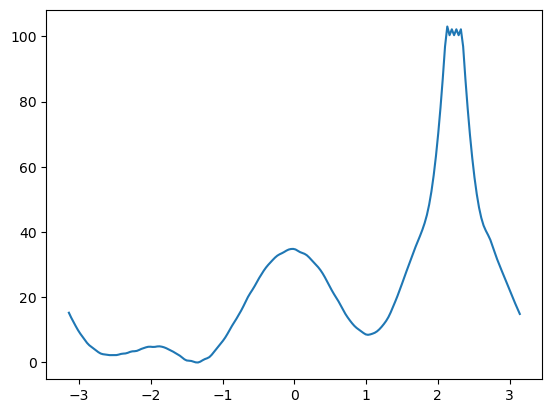

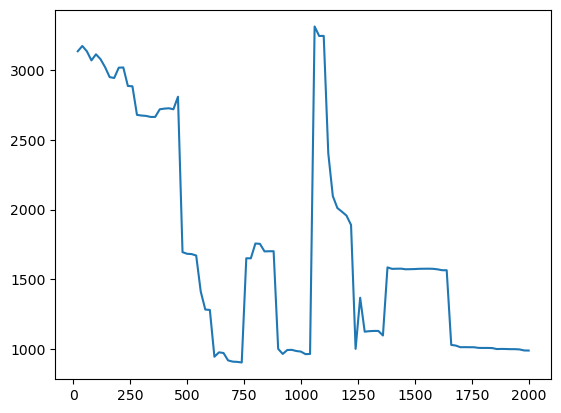

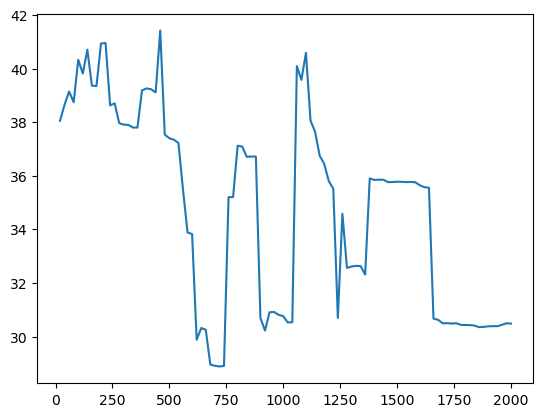

In [20]:
start = time.time()

[grid, Ftot_dens, Ftot_den2s, Ftots, ofv_nums, ofv, ofe, error_history_collection] = MFI_1D_numba(HILLS=HILLS, position=position, log_pace=1,
           error_pace=100, WellTempered=1, nhills=int(nhills), periodic=1)

FESs = intg_1D(Ftots, grid_space)

t_numba = time.time()-start	
print("time for >>MFI_numba<< is:", t_numba)
print("time saving:", round(100*(t_normal - t_numba)/t_normal, 2), "%")

	
print("\nERROR:")
print("differecen in Ftot_den:", sum(abs(Ftot_den - Ftot_dens)) / nbins)
print("differecen in Ftot_den2:", sum(abs(Ftot_den2 - Ftot_den2s)) / nbins)
print("differecen in Ftot_x:", sum(abs(Ftot - Ftots)) / nbins)
print("differecen in ofv_num_x:", sum(abs(ofv_num - ofv_nums)) / nbins)
print("differecen in FES:", sum(abs(FES-FESs)) / nbins, "\n\n")


start = time.time()

grid, Ftot_dens, Ftot_den2s, Ftots, ofv_nums, ofv, ofe, FESs, error_history_collection = MFI_1D_numba2(HILLS=HILLS, position=position, log_pace=1,
           error_pace=100, WellTempered=1, nhills=int(nhills), periodic=1)

t_numba2 = time.time()-start	
print("time for >>MFI_numba2<< is:", t_numba2)
print("time saving:", round(100*(t_normal - t_numba2)/t_normal, 2), "%")

	
print("\nERROR:")
print("differecen in Ftot_den:", sum(abs(Ftot_den - Ftot_dens)) / nbins)
print("differecen in Ftot_den2:", sum(abs(Ftot_den2 - Ftot_den2s)) / nbins)
print("differecen in Ftot_x:", sum(abs(Ftot - Ftots)) / nbins)
print("differecen in ofv_num_x:", sum(abs(ofv_num - ofv_nums)) / nbins)
print("differecen in FES:", sum(abs(FES-FESs)) / nbins)

plt.plot(grid, FESs); plt.show()

plt.plot(error_history_collection[:,2], error_history_collection[:,0]); plt.show()
plt.plot(error_history_collection[:,2], error_history_collection[:,1]); plt.show()


### (3) No-Loop method

In [24]:
def find_periodic_point(coord_array, min_grid, max_grid, periodic, grid_ext, grid_length):

    len_coord_array = len(coord_array)

    if periodic == 0:
        return coord_array
    elif periodic == 1:
        for i in range(len_coord_array):
            if coord_array[i] < min_grid+grid_ext:
                coord_array = np.append(coord_array, coord_array[i] + grid_length)
            elif coord_array[i] > max_grid-grid_ext:
                coord_array = np.append(coord_array, coord_array[i] - grid_length)
        return coord_array 
    
@njit
def find_periodic_point_numpy(coord_array, min_grid, max_grid, periodic, grid_ext, grid_length):

    len_coord_array = len(coord_array)

    if periodic == 0:
        return coord_array
    elif periodic == 1:
        for i in range(len_coord_array):
            if coord_array[i] < min_grid+grid_ext:
                coord_array = np.append(coord_array, coord_array[i] + grid_length)
            elif coord_array[i] > max_grid-grid_ext:
                coord_array = np.append(coord_array, coord_array[i] - grid_length)
        return coord_array    
    
@njit
def window_forces_noloop(periodic_positions, periodic_hills, grid, sigma_meta2, height_meta, kT, const, bw2, Ftot_den_limit):
    
    #Fbias force    
    # Fbias_window = np.zeros(nbins)
    grid_broadcast = np.broadcast_to(grid, (len(periodic_hills),) + grid.shape)
    periodic_hills = np.expand_dims(periodic_hills, axis=1)
    diff_pos = grid_broadcast - periodic_hills
    
    kernelmeta = np.exp( - np.square(diff_pos) / (2*sigma_meta2) )
    Fbias_window = height_meta / sigma_meta2 * np.multiply(kernelmeta, (diff_pos)) 
    Fbias_window = np.sum(Fbias_window, axis=0)

        
    #Fpbt force   
    grid_broadcast = np.broadcast_to(grid, (len(periodic_positions),) + grid.shape)
    periodic_positions = np.expand_dims(periodic_positions, axis=1)
    diff_pos = grid_broadcast - periodic_positions
    
    kernel = const * np.exp( - np.square(diff_pos) / (2 * bw2))
    pb_t = np.sum(kernel, axis=0)
    
    Fpbt_kernel = kT / bw2 * np.multiply(kernel, diff_pos)
    Fpbt = np.sum(Fpbt_kernel, axis=0)

    pb_t = np.where(pb_t > Ftot_den_limit, pb_t, 0)  # truncated probability density of window
    
    return [pb_t, Fpbt, Fbias_window]


def MFI_1D_noloop(HILLS="HILLS", position="position", bw=0.05, kT=2.49, min_grid=-np.pi, max_grid=np.pi, nbins=200, log_pace=10,
           error_pace=200, WellTempered=1, nhills=-1, periodic=0, hp_centre=0.0, hp_kappa=0, lw_centre=0.0, lw_kappa=0,
           uw_centre=0.0, uw_kappa=0, Ftot_den_limit = 1E-10):
 
    for initialise_constant in range(1):
        grid = np.linspace(min_grid, max_grid, nbins)
        grid_space = (max_grid - min_grid) / (nbins-1)
        stride = int(len(position) / len(HILLS[:, 1]))
        const = (1 / (bw * np.sqrt(2 * np.pi) * stride))
        bw2 = bw ** 2
        if nhills > 0: total_number_of_hills = nhills
        else: total_number_of_hills = len(HILLS)
        
        # initialise force terms
        Fbias = np.zeros(nbins)
        F_static = np.zeros(nbins)
        Ftot_num = np.zeros(nbins)
        Ftot_den = np.zeros(nbins)
        Ftot_den2 = np.zeros(nbins)
        ofv_num = np.zeros(nbins)
        
        ofv_history = []
        ofe_history = []
        time_history = []

        # Definition Gamma Factor, allows to switch between WT and regular MetaD
        if WellTempered < 1:
            Gamma_Factor = 1
        else:
            gamma = HILLS[0, 4]
            Gamma_Factor = (gamma - 1) / (gamma)
            
    for i in range(total_number_of_hills):
                
        # Load data
        s = HILLS[i, 1] 
        sigma_meta2 = HILLS[i, 2] ** 2 
        height_meta = HILLS[i, 3] * Gamma_Factor
        data = position[i * stride: (i + 1) * stride]          
        periodic_hills = find_periodic_point(np.array([s]), min_grid, max_grid, periodic, grid_ext, grid_length)
        periodic_positions = find_periodic_point(np.array(data), min_grid, max_grid, periodic, grid_ext, grid_length)
        
        #Estimate force due to bias        
        for j in range(len(periodic_hills)):
            kernelmeta = np.exp( - np.square(grid - periodic_hills[j]) / (2*sigma_meta2) )
            Fbias += height_meta / sigma_meta2 * np.multiply(kernelmeta, (grid - periodic_hills[j]))
        
        # Estimate the biased proabability density
        periodic_positions = np.expand_dims(periodic_positions, axis=1)
        grid_broadcast = np.broadcast_to(grid, (len(periodic_positions),)+grid.shape)
        diff = grid_broadcast - periodic_positions
        
        kernel = const * np.exp( - np.square(diff) / (2*bw2))
        pb_t = np.sum(kernel, axis=0)
        Fpbt_kernel = kT/bw2 * np.multiply(kernel, diff)
        Fpbt = np.sum(Fpbt_kernel, axis=0)
        pb_t = np.where(pb_t > Ftot_den_limit, pb_t, 0)  # truncated probability density of window
    
        # Estimate of the Mean Force and error  for terms
        Ftot_den += pb_t  # total probability density             
        dfds = np.divide(Fpbt, pb_t, out=np.zeros_like(Fpbt), where=pb_t > Ftot_den_limit) + Fbias - F_static
        Ftot_num += np.multiply(pb_t, dfds)
        Ftot = np.divide(Ftot_num, Ftot_den, out=np.zeros_like(Ftot_num), where=Ftot_den > Ftot_den_limit)  # total force

        # terms for error calculation
        Ftot_den2 += np.square(pb_t) 
        ofv_num += np.multiply(pb_t, np.square(dfds))  

        # Calculate error
        if (i + 1) % int(total_number_of_hills / error_pace) == 0 or (i+1) == total_number_of_hills:
            
            ofv = np.divide(ofv_num , Ftot_den, out=np.zeros_like(Ftot_den), where=Ftot_den > Ftot_den_limit) - np.square(Ftot)
            ofv *= np.divide(Ftot_den**2 , (Ftot_den**2-Ftot_den2), out=np.zeros_like(Ftot_den), where=(Ftot_den**2-Ftot_den2) > 0)
            ofe = np.sqrt(ofv)
                                    
            ofv_history.append(sum(ofv) / np.count_nonzero(ofv))
            ofe_history.append(sum(ofe) / np.count_nonzero(ofe))
            time_history.append(HILLS[i,0])            
            if (i + 1) % int(total_number_of_hills / log_pace) == 0:
                print(str(round((i + 1) / total_number_of_hills * 100, 0)) + "%   OFE =", round(ofe_history[-1], 4))
    
    FES = intg_1D(Ftots, grid_space)
    return [grid, Ftot_den, Ftot_den2, Ftot, ofv_num, ofv, ofe, FES, ofv_history, ofe_history, time_history]

@njit
def MFI_1D_noloop_numba(HILLS="HILLS", position="position", bw=0.05, kT=2.49, min_grid=-np.pi, max_grid=np.pi, nbins=200, log_pace=10,
           error_pace=200, WellTempered=1, nhills=-1, periodic=0, hp_centre=0.0, hp_kappa=0, lw_centre=0.0, lw_kappa=0,
           uw_centre=0.0, uw_kappa=0, Ftot_den_limit = 1E-10):
 
    for initialise_constant in range(1):
        grid = np.linspace(min_grid, max_grid, nbins)
        grid_space = (max_grid - min_grid) / (nbins-1)
        stride = int(len(position) / len(HILLS[:, 1]))
        const = (1 / (bw * np.sqrt(2 * np.pi) * stride))
        bw2 = bw ** 2
        if nhills > 0: total_number_of_hills = nhills
        else: total_number_of_hills = len(HILLS)
        
        # initialise force terms
        Fbias = np.zeros(nbins)
        F_static = np.zeros(nbins)
        Ftot_num = np.zeros(nbins)
        Ftot_den = np.zeros(nbins)
        Ftot_den2 = np.zeros(nbins)
        ofv_num = np.zeros(nbins)
        
        error_history_collection = np.zeros((int(error_pace), 3))
        error_count = 0

        # Definition Gamma Factor, allows to switch between WT and regular MetaD
        if WellTempered < 1:
            Gamma_Factor = 1
        else:
            gamma = HILLS[0, 4]
            Gamma_Factor = (gamma - 1) / (gamma)
            
    for i in range(total_number_of_hills):
        
        #Get position data of window        
        s = HILLS[i, 1] 
        sigma_meta2 = HILLS[i, 2] ** 2 
        height_meta = HILLS[i, 3] * Gamma_Factor
        data = position[i * stride: (i + 1) * stride]       
        # print(type(data))        
        periodic_hills = find_periodic_point_numpy(np.array([s]), min_grid, max_grid, periodic, grid_ext, grid_length)
        periodic_positions = find_periodic_point_numpy(data, min_grid, max_grid, periodic, grid_ext, grid_length)
         
        # Find forces of window
        [pb_t, Fpbt, Fbias_window] = window_forces_noloop(periodic_positions, periodic_hills, grid, sigma_meta2, height_meta, kT, const, bw2, Ftot_den_limit)
        # pb_t = np.ones(nbins)
        # Fpbt = np.ones(nbins)
        # Fbias_window = np.ones(nbins)

        # Estimate of the Mean Force
        Ftot_den += pb_t  # total probability density             
        Fbias += Fbias_window
        
        # dfds = np.divide(Fpbt, pb_t, out=np.zeros_like(pb_t), where=pb_t > Ftot_den_limit) + Fbias - F_static
        dfds = np.where(pb_t > Ftot_den_limit, Fpbt / pb_t, 0) + Fbias - F_static
        Ftot_num += np.multiply(pb_t, dfds)
        # Ftot = np.divide(Ftot_num, Ftot_den, out=np.zeros_like(Ftot_den), where=Ftot_den > Ftot_den_limit)
        Ftot = np.where(Ftot_den > Ftot_den_limit, Ftot_num / Ftot_den, 0)

        # terms for error calculation
        Ftot_den2 += np.square(pb_t) 
        ofv_num += np.multiply(pb_t, np.square(dfds))  

        # Calculate error
        if (i + 1) % int(total_number_of_hills / error_pace) == 0 or (i+1) == total_number_of_hills:
            
            # ofv = np.divide(ofv_num, Ftot_den, out=np.zeros_like(Ftot_den), where=Ftot_den > Ftot_den_limit) - np.square(Ftot)
            ofv = np.where(Ftot_den > Ftot_den_limit, ofv_num / Ftot_den, 0) - np.square(Ftot)
            # ofv *= np.divide(Ftot_den**2, (Ftot_den**2-Ftot_den2), out=np.zeros_like(Ftot_den), where=(Ftot_den**2-Ftot_den2) > 0)
            ofv *= np.where((Ftot_den**2-Ftot_den2) > 0, Ftot_den**2 / (Ftot_den**2-Ftot_den2), 0)
            ofe = np.where(ofv != 0, np.sqrt(ofv), 0)
              
            
            error_history_collection[error_count,0] = sum(ofv) / np.count_nonzero(ofv)
            error_history_collection[error_count,1] = sum(ofe) / np.count_nonzero(ofe)
            error_history_collection[error_count,2] = HILLS[i,0]
            error_count += 1

            if (i + 1) % int(total_number_of_hills / log_pace) == 0:
                print(round((i + 1) / total_number_of_hills * 100, 0) , "%   OFE =", round(error_history_collection[error_count-1,1], 4))
    
    return grid, Ftot_den, Ftot_den2, Ftot, ofv_num, ofv, ofe, error_history_collection

100.0%   OFE = 30.4869
time for >>MFI_noloop<< is: 2.092223882675171
time saving: 31.52 %

ERROR:
differecen in Ftot_den: 3.2018832030189514e-15
differecen in Ftot_den2: 1.7088552795030408e-14
differecen in Ftot_x: 4.564959521502487e-15
differecen in ofv_num_x: 3.126771858119083e-10
differecen in FES: 2.504663143554353e-15
100.0 %   OFE = 30.4869


time for >>MFI_noloop_numba<< is: 0.6398184299468994
time saving: 79.06 %

ERROR:
differecen in Ftot_den: 3.2018832030189514e-15
differecen in Ftot_den2: 1.7088552795030408e-14
differecen in Ftot_x: 4.564959521502487e-15
differecen in ofv_num_x: 3.126771858119083e-10
differecen in FES: 2.504663143554353e-15


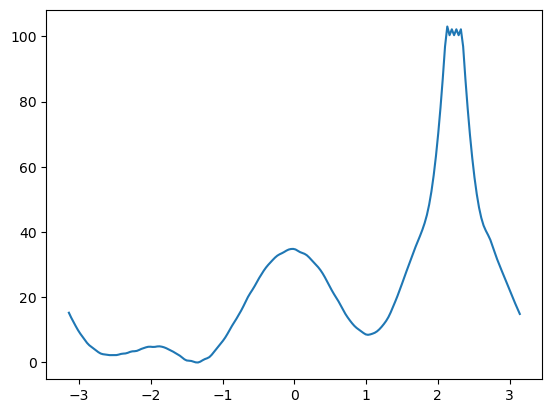

In [27]:
start = time.time()

[grid, Ftot_dens, Ftot_den2s, Ftots, ofv_nums, ofv, ofe, FESs, ofv_history, ofe_history, time_history] = MFI_1D_noloop(HILLS=HILLS, position=position, log_pace=1,
           error_pace=nhills/100, WellTempered=1, nhills=nhills, periodic=1)

t_noloop = time.time()-start	
print("time for >>MFI_noloop<< is:", t_noloop)
print("time saving:", round(100*(t_normal - t_noloop)/t_normal, 2), "%")

	
print("\nERROR:")
print("differecen in Ftot_den:", sum(abs(Ftot_den - Ftot_dens)) / nbins)
print("differecen in Ftot_den2:", sum(abs(Ftot_den2 - Ftot_den2s)) / nbins)
print("differecen in Ftot_x:", sum(abs(Ftot - Ftots)) / nbins)
print("differecen in ofv_num_x:", sum(abs(ofv_num - ofv_nums)) / nbins)
print("differecen in FES:", sum(abs(FES-FESs)) / nbins)


start = time.time()

grid, Ftot_dens, Ftot_den2s, Ftots, ofv_nums, ofv, ofe, error_history_collection = MFI_1D_noloop_numba(HILLS=HILLS, position=position, log_pace=1,
           error_pace=nhills/100, WellTempered=1, nhills=nhills, periodic=1)

FESs = intg_1D(Ftots, grid_space)

t_noloop_numba = time.time()-start	
print("\n\ntime for >>MFI_noloop_numba<< is:", t_noloop_numba)
print("time saving:", round(100*(t_normal - t_noloop_numba)/t_normal, 2), "%")

	
print("\nERROR:")
print("differecen in Ftot_den:", sum(abs(Ftot_den - Ftot_dens)) / nbins)
print("differecen in Ftot_den2:", sum(abs(Ftot_den2 - Ftot_den2s)) / nbins)
print("differecen in Ftot_x:", sum(abs(Ftot - Ftots)) / nbins)
print("differecen in ofv_num_x:", sum(abs(ofv_num - ofv_nums)) / nbins)
print("differecen in FES:", sum(abs(FES-FESs)) / nbins)


plt.plot(grid, FESs); plt.show()

### Plot differences

In [60]:
# plt.figure(1)
# plt.contourf(X,Y,FESs)
# plt.colorbar()
# plt.scatter(HILLS[:n_eval,1], HILLS[:n_eval,2], c="r", s=2)

# plt.figure(4)
# plt.contourf(X,Y,FES)
# plt.colorbar()
# plt.scatter(HILLS[:n_eval,1], HILLS[:n_eval,2], c="r", s=2)


# # plt.figure(2)
# # plt.contourf(X,Y,Ftot_xs, levels = np.linspace(-160, 160, 21))
# # plt.colorbar()
# # plt.scatter(HILLS[:n_eval,1], HILLS[:n_eval,2], c="r", s=2)

# # plt.figure(5)
# # plt.contourf(X,Y,Ftot_x, levels = np.linspace(-160, 160, 21))
# # plt.colorbar()
# # plt.scatter(HILLS[:n_eval,1], HILLS[:n_eval,2], c="r", s=2)

# plt.figure(6)
# plt.contourf(X,Y,Ftot_x-Ftot_xs)
# plt.colorbar()
# plt.scatter(HILLS[:n_eval,1], HILLS[:n_eval,2], c="r", s=2)

# plt.show()